<a href="https://colab.research.google.com/github/yanann11/nebius_llm_course/blob/main/topic1/1.1_intro_to_llm_apis_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMOps Essentials, practice 1.1. Intro to LLM APIs

# Practice solutions

# **Setting up**

In [3]:
!pip install -q openai

In [4]:
import os

from google.colab import files
uploaded = files.upload()


with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

Saving openai_api_key to openai_api_key
Saving nebius_api_key to nebius_api_key


# Practice: simple LLM applications

**Task 1. A (somewhat) safe LLM**

When asking an LLM to edit a text you’ve written, have you ever changed company or people’s names to avoid exposing private data to the LLM provider? We do! Doing this manually is quite annoying, so we'll automate this!

In this task, you'll create a wrapper that replaces selected words with innocent alternatives before calling an LLM, then restores the original text afterward.

We've prepared a template for you. Please fill in the `#<YOUR CODE HERE>` parts. If you struggle, don't hesitate to ank an LLM ;) Just be sure to test the resulting code!

In [5]:
import re

class LLMPrivacyWrapper:
    def __init__(self, replacement_map: dict):
        """
        Initializes the wrapper with a mapping of words to their replacements.

        replacement_map: Dictionary where keys are sensitive words and values are their innocent replacements.
        """
        self.replacement_map = replacement_map
        self.reverse_map = {v: k for k, v in replacement_map.items()}  # Reverse for decoding

    def encode(self, text: str) -> str:
        """
        Replaces sensitive words with innocent alternatives.

        text: Input text containing sensitive words.

        return: Encoded text with innocent replacements.
        """
        def replace_match(match):
            word = match.group(0)
            return self.replacement_map.get(word, word)  # Replace if found, else keep the same

        pattern = re.compile(r'\b(' + '|'.join(map(re.escape, self.replacement_map.keys())) + r')\b', re.IGNORECASE)
        return pattern.sub(replace_match, text)

    def decode(self, text: str) -> str:
        """
        Restores original sensitive words in the text.

        text: Encoded text with innocent replacements.

        return: Decoded text with original words restored.
        """
        def replace_match(match):
            word = match.group(0)
            return self.reverse_map.get(word, word)

        pattern = re.compile(r'\b(' + '|'.join(map(re.escape, self.reverse_map.keys())) + r')\b', re.IGNORECASE)
        return pattern.sub(replace_match, text)

    def answer_with_llm(self, text: str, client, model: str) -> str:
        """
        Encodes text, sends it to the LLM, and then decodes the response.

        text: The original input text.
        client: an LLM client, e.g., OpenAI() or Nebius client.
        model: a model name, e.g., "gpt-4o-mini".

        return: The final processed text with original words restored.
        """
        encoded_text = self.encode(text)

        completion = client.chat.completions.create(
            model=model,
            messages=[
                {
                  "role": "user",
                  "content": encoded_text
                }
            ],
            temperature=None
        )

        llm_response = completion.choices[0].message.content
        return self.decode(llm_response)

In [8]:
my_wrapper = LLMPrivacyWrapper(
    {"Hogwarts": "Hogsmith State Secondary School",
     "Albus Dumbledore": "Merlin",
     "Ministry of Magic": "London Bureau of Immigration and Statistics"}
)

prompt = """Edit the following announcement in a natural and supportive English.
Add some appropriate emoji to liven up the message. Explain your edits.

Human Resource Department

Important information for all employees

Dear workers of Hogwarts,

We must inform you of many issues which are now of importance. Hogwarts, as you all know, still under the leadership of Albus Dumbledore, even if sometimes it feels like rules do not apply here. However, as the Ministry of Magic keeps reminding us, we have responsibilities, and therefore you must pay attention.

First of all, Ministry of Magic people are coming. They will do inspection for checking on safety and teaching. This is requirement, do not argue. They will be in all classrooms and dungeons. If you are hiding things you should not have, better to do something about it now, before they see.

Second, regarding House-Elves. We see again that some staff are using them in magical experiments. This is not allowed! Stop doing this, or we will be forced to write reports. Albus Dumbledore says this is “highly inappropriate,” and honestly, so do we.

This is all. Try not to make more problems.

— Hogwarts HR Office
"""
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

result = my_wrapper.answer_with_llm(prompt,
                                           client=client, model=model)

print(result)

Here's the edited announcement with a more natural and supportive tone, along with some added emojis to make the message more engaging:

**Important Updates from the HR Department 📣**

Dear Hogwarts Team,

We hope this message finds you well! We wanted to touch base with you regarding a few important updates that affect everyone in our school community.

**Upcoming Inspection 🕵️‍♀️**

As you may know, the Ministry of Magic will be visiting our school soon to conduct a safety and teaching inspection. This is a routine check to ensure we're meeting the required standards. Please make sure your classrooms and work areas are tidy and organized, and that you're following all safety protocols.

**Reminder: Respect for House-Elves 🧝‍♀️**

We've been reminded that some staff members have been using House-Elves in magical experiments. We want to reiterate that this is not allowed and can have serious consequences. We kindly ask that you refrain from engaging in such activities, as they are not 

In [ ]:
encoded_prompt = my_wrapper.encode(prompt)

print(encoded_prompt)

decoded_prompt = my_wrapper.decode(encoded_prompt)

assert decoded_prompt == prompt

Edit the following announcement in a natural and supportive English. 
Add some appropriate emoji. Explain your edits.

Human Resource Department

Important information for all employees

Dear workers of Hogsmith State Secondary School,

We must inform you of many issues which are now of importance. Hogsmith State Secondary School, as you all know, still under the leadership of Merlin, even if sometimes it feels like rules do not apply here. However, as the London Bureau of Immigration and Statistics keeps reminding us, we have responsibilities, and therefore you must pay attention.

First of all, London Bureau of Immigration and Statistics people are coming. They will do inspection for checking on safety and teaching. This is requirement, do not argue. They will be in all classrooms and dungeons. If you are hiding things you should not have, better to do something about it now, before they see.

Second, regarding House-Elves. We see again that some staff are using them in magical exper

## Task 2. "Broken telephone"

In this task, we suggest you to implement the game of "Broken telephone" with a text-to-image model and a multimodal LLM. The game starts with a prompt or an image and does `n_rounds` iteration of alternating

* Creating an image from a text prompt.
* Creating a textual description of an image with a multimodal LLM.

Run several iterations and observe how far (or not) the process will go from the original media!

In [9]:
import os
import base64
import json
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
from openai import OpenAI
from typing import Optional, Tuple, List
import logging

from tqdm import tqdm

class BrokenTelephone:
    def __init__(
        self,
        client: OpenAI,
        text2image_model: str = "black-forest-labs/flux-dev",
        multimodal_llm: str = "Qwen/Qwen2-VL-72B-Instruct"
    ):
        """
        Initialize the Broken Telephone game.

        Args:
            api_key: Nebius API key
            base_url: API base URL
            text2image_model: Model for image generation
            multimodal_llm: Model for image description
        """
        self.client = client
        self.text2image_model = text2image_model
        self.multimodal_llm = multimodal_llm
        self.history = []
        self.staring_with_image = None

        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def generate_image(self, prompt: str) -> Tuple[Image.Image, str]:
        """
        Generate an image from a text prompt.

        Args:
            prompt: Text prompt for image generation

        Returns:
            Tuple of (PIL Image, base64 string of image)
        """
        self.logger.info(f"Generating image for prompt: {prompt}")

        try:
            response = self.client.images.generate(
                model=self.text2image_model,
                response_format="b64_json",
                extra_body={
                    "response_extension": "png",
                    "width": 1024,
                    "height": 1024,
                    "num_inference_steps": 28,
                    "negative_prompt": "",
                    "seed": -1
                },
                prompt=prompt
            )

            response_data = json.loads(response.to_json())
            b64_image = response_data['data'][0]['b64_json']
            image_bytes = base64.b64decode(b64_image)
            image = Image.open(BytesIO(image_bytes))

            return image, b64_image

        except Exception as e:
            self.logger.error(f"Error generating image: {str(e)}")
            raise

    def describe_image(self, b64_image: str,
                       system_prompt: Optional[str] = "You are a helpful assistant") -> str:
        """
        Generate a description of an image using the multimodal LLM.

        Args:
            b64_image: Base64 encoded image
            system_prompt: Optional system prompt for the LLM

        Returns:
            String description of the image
        """
        self.logger.info("Generating image description")

        messages = []

        if system_prompt:
            messages.append({"role": "system", "content": system_prompt})

        messages.append(
            {"role": "user", "content": [
                        {"type": "text", "text": "Describe the following image in detail."},
                        {"type": "image_url", "image_url": {
                            "url": f"data:image/png;base64,{b64_image}"}
                        }
                    ]}
        )

        try:
            completion = self.client.chat.completions.create(
                model=self.multimodal_llm,
                messages=messages,
                temperature=None
            )

            description = completion.choices[0].message.content
            return description

        except Exception as e:
            self.logger.error(f"Error describing image: {str(e)}")
            raise

    def play_round(
        self,
        starting_prompt: Optional[str] = None,
        starting_image: Optional[Tuple[Image.Image, str]] = None,
    ) -> Tuple[str, Image.Image]:
        """
        Play one round of the game, either starting with a prompt or an image.

        Args:
            starting_prompt: Text prompt to start with
            starting_image: Tuple of (PIL Image, base64 string) to start with

        Returns:
            Tuple of (final description, final image)
        """
        if starting_prompt is None and starting_image is None:
            raise ValueError("Must provide either starting_prompt or starting_image")

        if not self.staring_with_image:
            # Start with text -> image
            image, b64_image = self.generate_image(starting_prompt)
            description = self.describe_image(b64_image)
            return description, image
        else:
            # Start with image -> text
            image, b64_image = starting_image
            description = self.describe_image(b64_image)
            new_image, _ = self.generate_image(description)
            return description, new_image

    def play_game(
        self,
        n_rounds: int,
        starting_prompt: Optional[str] = None,
        starting_image: Optional[Tuple[Image.Image, str]] = None,
        save_path: Optional[str] = None
    ) -> List[Tuple[str, Image.Image]]:
        """
        Play multiple rounds of the game.

        Args:
            n_rounds: Number of rounds to play
            starting_prompt: Optional text prompt to start with
            starting_image: Optional image to start with
            save_path: Optional path to save results

        Returns:
            List of (description, image) pairs for each round
        """
        self.history = []
        current_prompt = starting_prompt
        current_image = starting_image
        if current_prompt is None and current_image is None:
            raise ValueError("Must provide either starting_prompt or starting_image")
        elif current_prompt:
            self.staring_with_image = False
        else:
            self.staring_with_image = True

        self.logger.info(f"Starting game with {n_rounds} rounds")

        for i in tqdm(range(n_rounds)):
            self.logger.info(f"Playing round {i+1}")
            description, image = self.play_round(
                starting_prompt=current_prompt,
                starting_image=current_image
            )
            self.history.append((description, image))

            # Next round starts with the description
            current_prompt = description
            current_image = None

            if save_path:
                self._save_round(i, description, image, save_path)

        return self.history

    def visualize_history(self, image_size: Tuple[int, int] = (8, 8)) -> None:
        """
        Visualize the game history with alternating text descriptions and images.

        Args:
            image_size: Size for each image plot (width, height)
        """
        n_rounds = len(self.history)

        for i, (description, image) in enumerate(self.history):

            print(f"\n{'='*80}")
            print(f"Round {i+1}")
            print(f"{'='*80}")

            if self.staring_with_image:
                # Print full description
                print(f"{'='*80}")
                print(f"Description: {description}")
                print(f"{'='*80}")

                # Create a new figure for each image
                plt.figure(figsize=image_size)
                plt.imshow(image)
                plt.axis('off')
                plt.title(f'Round {i+1} Image')
                plt.show()
                plt.close()
            else:
                # Create a new figure for each image
                plt.figure(figsize=image_size)
                plt.imshow(image)
                plt.axis('off')
                plt.title(f'Round {i+1} Image')
                plt.show()
                plt.close()

                # Print full description
                print(f"{'='*80}")
                print(f"Description: {description}")
                print(f"{'='*80}")

    def _save_round(
        self,
        round_num: int,
        description: str,
        image: Image.Image,
        save_path: str
    ) -> None:
        """
        Save the results of a round to disk.

        Args:
            round_num: Round number
            description: Text description
            image: PIL Image
            save_path: Base path to save to
        """
        os.makedirs(save_path, exist_ok=True)

        # Save description
        with open(os.path.join(save_path, f'round_{round_num}_description.txt'), 'w') as f:
            f.write(description)

        # Save image
        image.save(os.path.join(save_path, f'round_{round_num}_image.png'))

100%|██████████| 3/3 [01:00<00:00, 20.13s/it]



Round 1


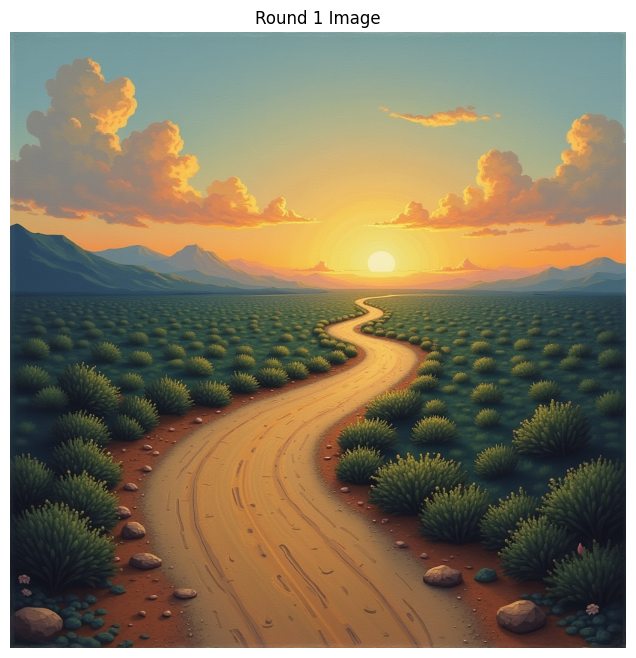

Description: The image depicts a serene and picturesque landscape at sunset. The scene is dominated by a winding dirt road that meanders through a vast, open field. The road is flanked by lush green bushes and small rocks, creating a natural pathway that draws the viewer's eye towards the horizon.

In the distance, the road leads to a range of mountains, their silhouettes softly lit by the golden hues of the setting sun. The sky is a beautiful gradient of colors, transitioning from a warm orange near the horizon to a cooler blue higher up, dotted with fluffy, white clouds that are tinged with the sun's warm glow.

The overall atmosphere of the image is peaceful and tranquil, evoking a sense of calm and contemplation. The interplay of light and shadow, combined with the natural beauty of the landscape, creates a visually striking and emotionally soothing scene.

Round 2


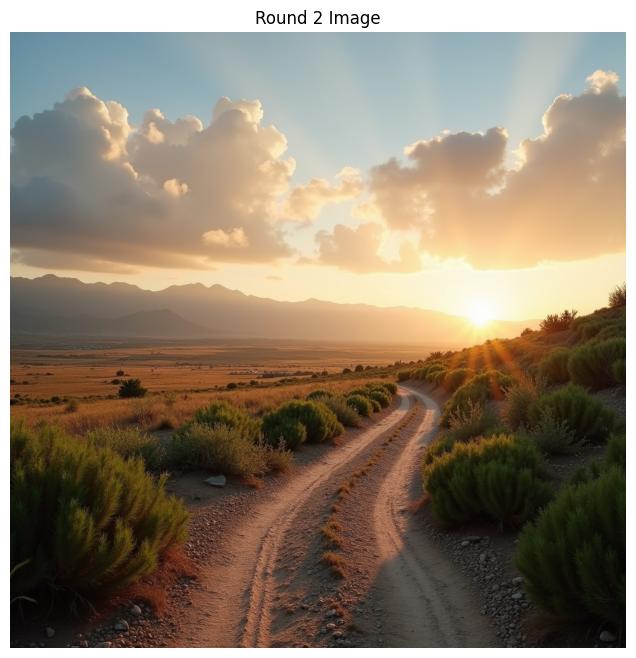

Description: The image depicts a serene and picturesque landscape during sunset. The scene is dominated by a winding dirt road that leads through a gently rolling terrain. The road is flanked by lush green shrubs and small bushes, adding a sense of vibrancy to the otherwise earthy tones of the landscape.

In the distance, a range of mountains can be seen, their silhouettes softly blurred by the atmospheric perspective. The mountains are bathed in the warm, golden hues of the setting sun, which is visible just above the horizon, casting long shadows and creating a dramatic interplay of light and shadow.

The sky is a stunning canvas of colors, transitioning from the deep blues of the upper atmosphere to the warm oranges and yellows near the horizon. Scattered clouds are illuminated by the sunlight, adding depth and texture to the sky. The overall atmosphere is tranquil and peaceful, evoking a sense of calm and contemplation.

Round 3


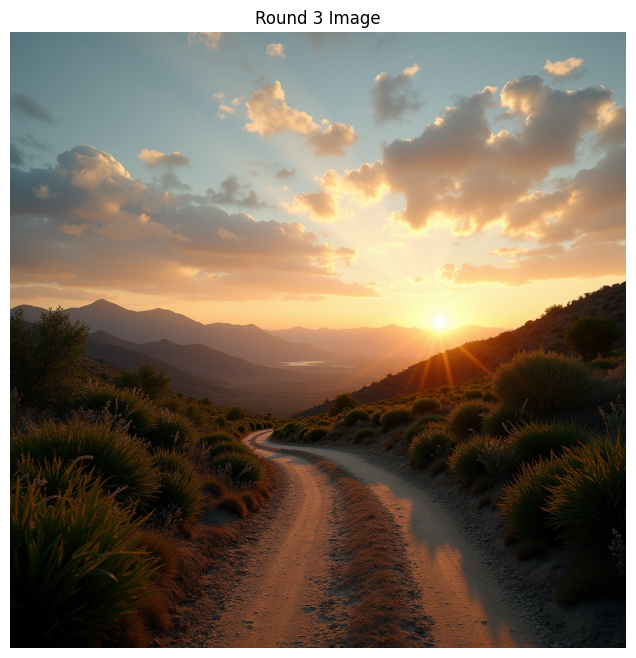

Description: The image depicts a serene and picturesque landscape during sunset. The sun is setting in the background, casting a warm, golden glow across the scene. The sky is a mix of soft shades of blue and orange, with scattered clouds illuminated by the sunlight.

In the foreground, there is a winding dirt road that leads into the distance, surrounded by lush vegetation. The road is flanked by various types of plants, including tall grasses and bushes. The terrain is hilly, with gentle slopes and a few small hills in the middle ground.

In the middle ground, there are more hills, which gradually become more distant and less distinct as they recede into the background. The background features a range of mountains that stretch across the horizon, their peaks faintly visible against the sky.

The overall atmosphere of the image is peaceful and tranquil, with the warm colors of the sunset and the natural beauty of the landscape creating a sense of calm and serenity.


In [10]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

game = BrokenTelephone(client=client)

# Start with a prompt
history = game.play_game(
    n_rounds=3,
    starting_prompt="We chose the road and we will follow where it leads.",
    save_path="broken_telephone_results"
)

# Visualize the results
game.visualize_history()

## Task 3\*. A very simple GenAI-powered service

If you used LLMs to do the previous task, you probably understand how much powerful LLMs are as coding assistants. So, we challenge you to try leveraging their power to turn the code you've created in **Task 2** into a full-fledged web service!

For now, create a simple app that you can launch in colab and call from another colab. In the end of week 1, we'll launch a cloud-based chat service, and you'll learn about some best practices of doing this. For now, cloud deployment may prove tough, if you haven't done this before.

Please be ready that the very first attempt may fail, the service refusing to start, crashing, and flooding you with outlandish errors. Take it easy and share the mistakes with the LLM in the same chat. After several iterations you should be fine! [Let Andrej Karpathy motivate you!](https://x.com/karpathy/status/1886192184808149383)

For the author of this notebook, it took about 12 iterations of "vibe coding" (that is, coding without thinking much about what's happening in the code) to get a working server.

**How to approach this with Anthropic Claude 3.5 Sonnet**

I actually started by creating the solution for task 2, using the following prompt:

```
Here's the task I'm creating:

## Task 2. "Broken telephone"
In this task, we suggest you to implement the game of "Broken telephone" with a text-to-image model and a multimodal LLM. The game starts with a prompt or an image and does n_rounds iteration of alternating
* Creating an image from a text prompt.
* Creating a textual description of an image with a multimodal LLM.
Run several iterations and observe how far (or not) the process will go from the original media!

And I need a reference solution for that.

## That's how I generate an image:

import os
from openai import OpenAI
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)
response = client.images.generate(
    model="black-forest-labs/flux-dev",
    response_format="b64_json",
    extra_body={
        "response_extension": "png",
        "width": 1024,
        "height": 1024,
        "num_inference_steps": 28,
        "negative_prompt": "",
        "seed": -1
    },
    prompt="An elven wizard is studying Machine Learning"
)
response_json = response.to_json()

import matplotlib.pyplot as plt
import base64
import json
from PIL import Image
from io import BytesIO
response_data = json.loads(response_json)
b64_image = response_data['data'][0]['b64_json']
image_bytes = base64.b64decode(b64_image)
image = Image.open(BytesIO(image_bytes))
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

## That's an example of how I work with a multimodal LLM:

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
base64_image = encode_image(IMAGE_PATH)
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "Qwen/Qwen2-VL-72B-Instruct"
completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are an expert pathfinder"},
        {"role": "user", "content": [
            {"type": "text", "text": geography_prompt},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ]
)
print(completion.choices[0].message.content)

## Your task
Please provide the reference solution
```

Notice the markdown structure; it helps the LLM to navigate the prompt.

After some in-dialogue polishing of the code, I used the same chat to solve Task 3, starting with:

*How can I turn this game into a very-very modest web service that runs from Google colab and can be called from a different machine (for example, from another google colab in a different browser tab)?*

After that, I only shared error messages with minimal (mildly emotional) comments. I deliberately avoided looking at the code and trying to make sense of it for the sake of experiment. In my case, Claude struggled with understanding how to open service running in Colab to external requests. At some point it even became desperate and asked:

*I apologize, but I realize I'm still making assumptions about Colab's features. Let me ask directly: How do you usually expose a web service running in Colab to the outside world? Do you use any specific Colab features or third-party tools for this?*

To which I firmly answered:

*What do you mean by "How do you usually expose a web service running in Colab to the outside world?"? How do I expose it? I have no idea; that's you who I'm asking about it!*

After 14 iterations, the code was finally fully functional.

**An example of task 3 solution**. This solution was created with Anthropic Claude 3.5 Sonnet.

### Server side

To test the solution, you'll need to get a `ngrock` token. That's how you do it:

1. Go to ngrok.com
2. Create a free account
3. Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
4. Pack your authtoken into the `ngrock_authtoken` file (no file extension)
5. Load it to colab

Ngrock will allow you to expose the service you're running in colab for the world.

In [ ]:
!pip uninstall -y flask flask-ngrok jinja2 markupsafe werkzeug
!pip install werkzeug==2.0.3
!pip install markupsafe==2.0.1
!pip install jinja2==2.11.3
!pip install flask==2.0.1
!pip install flask-ngrok
!pip install pyngrok

Found existing installation: Jinja2 2.11.3
Uninstalling Jinja2-2.11.3:
  Successfully uninstalled Jinja2-2.11.3
Found existing installation: MarkupSafe 3.0.2
Uninstalling MarkupSafe-3.0.2:
  Successfully uninstalled MarkupSafe-3.0.2
Found existing installation: Werkzeug 2.0.3
Uninstalling Werkzeug-2.0.3:
  Successfully uninstalled Werkzeug-2.0.3
  Using cached Werkzeug-2.0.3-py3-none-any.whl.metadata (4.5 kB)
Using cached Werkzeug-2.0.3-py3-none-any.whl (289 kB)
  Using cached MarkupSafe-2.0.1-cp311-cp311-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbconvert 7.16.6 requires jinja2>=3.0, which is not installed.
jupyter-server 1.24.0 requires jinja2, which is not installed.
  Using cached Jinja2-2.11.3-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached Jinja2-2.11.3-py2.py3-none-any.whl (125 kB)
ERROR: pip's dependency resolver does not curr

In [ ]:
import os

with open("ngrok_authtoken", "r") as file:
    ngrok_authtoken = file.read().strip()

os.environ["NGROK_AUTHTOKEN"] = ngrok_authtoken

In [ ]:
!pip install flask pyngrok

Now, this colab notebook will be our **server**. On it, run the following code:

In [ ]:
# === SERVER (run this in the first Colab notebook) ===

from flask import Flask, request, jsonify
import base64
from io import BytesIO
from PIL import Image
from pyngrok import ngrok

app = Flask(__name__)

# Initialize the game
game = None

def init_game(client):
    """Initialize the game with Nebius client"""
    global game
    game = BrokenTelephone(client=client)

@app.route('/play', methods=['POST'])
def play_game():
    try:
        data = request.json
        n_rounds = data.get('n_rounds', 3)
        starting_prompt = data.get('starting_prompt')

        if not starting_prompt:
            return jsonify({'error': 'starting_prompt is required'}), 400

        # Play the game
        history = game.play_game(n_rounds=n_rounds, starting_prompt=starting_prompt)

        # Convert history to serializable format
        serialized_history = []
        for description, image in history:
            # Convert PIL Image to base64
            buffered = BytesIO()
            image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            serialized_history.append({
                'description': description,
                'image': img_str
            })

        return jsonify({
            'status': 'success',
            'history': serialized_history
        })

    except Exception as e:
        return jsonify({'error': str(e)}), 500

def start_server(client):
    """Start the server with Nebius client"""
    try:
        # Initialize the game
        init_game(client)

        # Start ngrok
        public_url = ngrok.connect(5000)
        print(f"\nNgrok tunnel established at: {public_url}")
        print("Use this URL in your client notebook")

        # Start Flask app
        app.run(port=5000)
    except Exception as e:
        print(f"Error starting server: {str(e)}")

The next cell will launch a server. After that, you won't be able to do anything else in this notebook until you decide to hit "stop this cell" thus terminating the server.

The cell's output should look like

```
Ngrok tunnel established at: NgrokTunnel: "<COPY THIS!>" -> "http://localhost:5000"
Use this URL in your client notebook
 * Serving Flask app '__main__'
 * Debug mode: off
INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on <SOME_IP>
INFO:werkzeug:Press CTRL+C to quit
```

Now, copy the web address that we've marked as `<COPY_THIS>`. You'll need it in the **client** notebook. The client's code is below.

Also, in this cell's output you'll see tqdm progressbars and `"POST /play HTTP/1.1" 200 -` messages (hopefully) when the client will be querying the server. A message with code `200` is a success message. Other codes will tell you that something went wrong.

In [ ]:
# Initialize the client
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)

# Start the server
start_server(client)


Ngrok tunnel established at: NgrokTunnel: "https://2915-34-23-41-247.ngrok-free.app" -> "http://localhost:5000"
Use this URL in your client notebook
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
100%|██████████| 3/3 [00:44<00:00, 14.87s/it]
INFO:werkzeug:127.0.0.1 - - [09/Feb/2025 01:21:44] "POST /play HTTP/1.1" 200 -


### Client side

Now, open another colab notebook. It will be the **client**. Run the following code:

In [ ]:
import requests
import matplotlib.pyplot as plt
import base64
from PIL import Image
from io import BytesIO

def call_broken_telephone(server_url, starting_prompt, n_rounds=3):
    # Prepare the request
    data = {
        'starting_prompt': starting_prompt,
        'n_rounds': n_rounds
    }

    # Make the request
    response = requests.post(f'{server_url}/play', json=data)
    response.raise_for_status()

    # Process the response
    result = response.json()

    if result.get('error'):
        raise Exception(result['error'])

    # Visualize the results
    history = result['history']

    for i, round_data in enumerate(history):
        # Print description
        print(f"\n{'='*80}")
        print(f"Round {i+1}")
        print(f"{'='*80}")
        print(f"Description: {round_data['description']}")
        print(f"{'='*80}")

        # Display image
        img_data = base64.b64decode(round_data['image'])
        img = Image.open(BytesIO(img_data))

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Round {i+1} Image')
        plt.show()
        plt.close()

The next cell calls the server. Paste the `<COPY_THIS>` address as `<PASTE_HERE>`. Now, you can run this until you get bored :)
Just don't forget to terminate the server in the end!

Have fun!

In [ ]:
server_url = "<PASTE HERE>"  # Replace with the URL from the first notebook
starting_prompt = "An elven wizard is studying Machine Learning"
call_broken_telephone(server_url, starting_prompt, n_rounds=3)